In [236]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import kurtosis

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
mbl_nets = pd.read_csv('/content/drive/MyDrive/metrics_iclr_2022/mobilenets.csv')
resnets = pd.read_csv('/content/drive/MyDrive/metrics_iclr_2022/resnets_nets.csv')
distilled = pd.read_csv('/content/drive/MyDrive/metrics_iclr_2022/distilled.csv')
teachers = pd.read_csv('/content/drive/MyDrive/metrics_iclr_2022/teacher.csv')
pruned = pd.read_csv('/content/drive/MyDrive/metrics_iclr_2022/pruned.csv')
deit = pd.read_csv('/content/drive/MyDrive/metrics_iclr_2022/deit_patch16_224.csv')
regnety = pd.read_csv('/content/drive/MyDrive/metrics_iclr_2022/RegNetY-16GF.csv')
eff = pd.read_csv('/content/drive/MyDrive/metrics_iclr_2022/eff_1-4.csv')

In [4]:
def class_level_stats(ground_truth, predictions):
  conf_matrix = confusion_matrix(ground_truth, predictions)

  FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
  FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
  TP = np.diag(conf_matrix)
  TN = conf_matrix.sum() - (FP + FN + TP)

  FPR = FP / (FP  + TN)
  FNR = FN / (FN + TP)
  return FPR, FNR

In [5]:
def my_special_variance(error_rates):
  assert error_rates.ndim == 2, 'Error rates must be 2 dimensional'
  my_special_mean = error_rates.sum(axis=0)/[len(error_rates), len(error_rates)]
  sum_of_squares = 0
  for e in error_rates:
    sum_of_squares += ((my_special_mean[0]-e[0])**2 + (my_special_mean[1]-e[1])**2)
  return sum_of_squares/len(error_rates)


In [6]:
why_dict = {
    'model' : [],
    'top1': [],
    'top1_err': [],
    'top5': [],
    'top5_err': [],
    'param_count': [],
    'img_size': [],
    'cropt_pct': [],
    'interpolation': [],
    'ground_labels': [],
    'predictions': [],
}

for frame in [resnets, mbl_nets, distilled, pruned, teachers, deit, regnety, eff]:
  for i in range(len(frame)):

    model = frame.loc[i, 'model']
    top1 = frame.loc[i, 'top1']

    # don't need duplicates or weight-less models
    if model not in why_dict['model'] and top1 > 3:
      conv = np.array(frame.loc[i, 'ground_labels'][1:-1].split(','), dtype=int)
      why_dict['ground_labels'].append(conv)

      conv = np.array(frame.loc[i, 'predictions'][1:-1].split(','), dtype=int)
      why_dict['predictions'].append(conv)

      why_dict['model'].append(model)
      why_dict['top1'].append(top1)
      why_dict['top1_err'].append(frame.loc[i, 'top1_err'])
      why_dict['top5'].append(frame.loc[i, 'top5'])
      why_dict['top5_err'].append(frame.loc[i, 'top5_err'])
      why_dict['param_count'].append(frame.loc[i, 'param_count'])
      why_dict['img_size'].append(frame.loc[i, 'img_size'])
      why_dict['cropt_pct'].append(frame.loc[i, 'cropt_pct'])
      why_dict['interpolation'].append(frame.loc[i, 'interpolation'])



In [7]:
df = pd.DataFrame(why_dict)

In [53]:
df[df['model'].str.contains('efficientnet_el_pruned|efficientnet_b3_pruned')]

,model,top1,top1_err,top5,top5_err,param_count,img_size,cropt_pct,interpolation,ground_labels,predictions
31,efficientnet_b3_pruned,80.856,19.144,95.240,4.760,9.86,300,0.904,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 693, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
33,efficientnet_el_pruned,80.304,19.696,95.222,4.778,10.59,300,0.904,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."


In [72]:
FPR, FNR = class_level_stats(df.loc[34, 'ground_labels'], df.loc[31, 'predictions'])
f1 = classification_report(df.loc[34, 'ground_labels'], df.loc[31, 'predictions'], output_dict=True)
f1 = [v['f1-score'] for k, v in f1.items() if isinstance(v, dict)]

In [73]:
sns.set_theme()

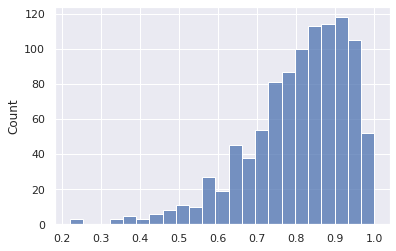

In [74]:
FPR, FNR = class_level_stats(df.loc[34, 'ground_labels'], df.loc[31, 'predictions'])
f1 = classification_report(df.loc[34, 'ground_labels'], df.loc[31, 'predictions'], output_dict=True)
f1 = [v['f1-score'] for k, v in f1.items() if isinstance(v, dict)]sns.histplot(x=f1)

0.7609647736693022 0.019085278559527893 0.3442665740740618 0.7590107651677438 0.01887163436546978 0.08082949050399657


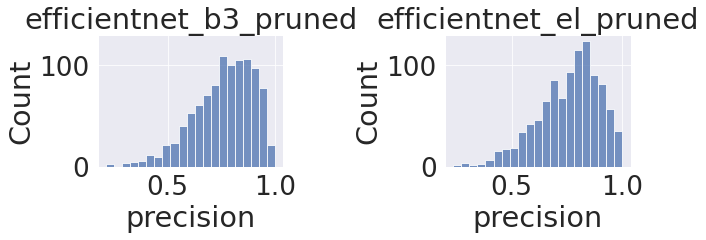

In [307]:


FPR, FNR = class_level_stats(df.loc[14, 'ground_labels'], df.loc[14, 'predictions'])
f1 = classification_report(df.loc[14, 'ground_labels'], df.loc[14, 'predictions'], output_dict=True)

f1 = [v['precision'] for k, v in f1.items() if isinstance(v, dict)]



FPR_2, FNR_2 = class_level_stats(df.loc[15, 'ground_labels'], df.loc[15, 'predictions'])
f1_2 = classification_report(df.loc[15, 'ground_labels'], df.loc[15, 'predictions'], output_dict=True)
f1_2 = [v['precision'] for k, v in f1_2.items() if isinstance(v, dict)]



comp = {
    "FPR": FPR.tolist() + FPR_2.tolist(), 
    "FNR": FNR.tolist() + FNR_2.tolist(), 
    'precision':  f1[:-2] + f1_2[:-2],
    "Model": ["efficientnet_b3_pruned" for i in range(FPR.size)] + ["efficientnet_el_pruned" for i in range(FNR.size)]
}
sns.set_theme("paper", font_scale=3)
ex = pd.DataFrame(comp)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(data=ex[ex['Model'] =='efficientnet_b3_pruned'], x='precision',   multiple='dodge')
plt.title('efficientnet_b3_pruned')
plt.ylim([0, 130])
plt.subplot(1, 2, 2)
sns.histplot(data=ex[ex['Model'] !='efficientnet_b3_pruned'], x='precision',  multiple='dodge')
plt.title('efficientnet_el_pruned')
plt.tight_layout()

plt.ylim([0, 130])
print(np.mean(f1), np.var(f1), kurtosis(f1), np.mean(f1_2), np.var(f1_2), kurtosis(f1_2))

In [282]:
ex.groupby('Model').describe()

FPR                      ... precision               
                         count      mean       std  ...       50%       75%  max
Model                                               ...                         
efficientnet_b3_pruned  1000.0  0.000243  0.000155  ...  0.777778  0.867925  1.0
efficientnet_el_pruned  1000.0  0.000244  0.000153  ...  0.781818  0.857143  1.0

[2 rows x 24 columns]

In [216]:
frem

1002

In [165]:
ex

,FPR,FNR,Model
0,0.00002,0.06,efficientnet_b3_pruned
1,0.00002,0.02,efficientnet_b3_pruned
2,0.00010,0.08,efficientnet_b3_pruned
3,0.00018,0.14,efficientnet_b3_pruned
4,0.00006,0.04,efficientnet_b3_pruned
...,...,...,...
1995,0.00002,0.00,efficientnet_el_pruned
1996,0.00008,0.08,efficientnet_el_pruned
1997,0.00028,0.18,efficientnet_el_pruned
1998,0.00038,0.48,efficientnet_el_pruned


In [141]:
ex.melt(id_vars=['Model'], value_vars=['FPR', 'FNR'], var_name='Error Type', value_name='Error Rate')

,Model,Error Type,Error Rate
0,efficientnet_b3_pruned,FPR,0.00002
1,efficientnet_b3_pruned,FPR,0.00002
2,efficientnet_b3_pruned,FPR,0.00010
3,efficientnet_b3_pruned,FPR,0.00018
4,efficientnet_b3_pruned,FPR,0.00006
...,...,...,...
3995,efficientnet_el_pruned,FNR,0.00000
3996,efficientnet_el_pruned,FNR,0.08000
3997,efficientnet_el_pruned,FNR,0.18000
3998,efficientnet_el_pruned,FNR,0.48000


(0.0, 1.1)

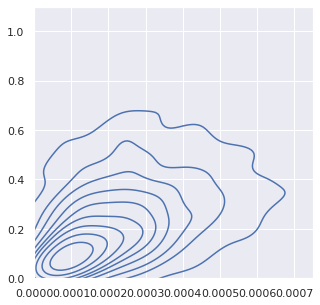

In [83]:
plt.figure(figsize=(5,5))
FPR, FNR = class_level_stats(df.loc[33, 'ground_labels'], df.loc[27, 'predictions'])
f1 = classification_report(df.loc[33, 'ground_labels'], df.loc[27, 'predictions'], output_dict=True)
f1 = [v['f1-score'] for k, v in f1.items() if isinstance(v, dict)]
sns.kdeplot(x=FPR, y=FNR)
plt.xlim([0, 0.00075])
plt.ylim([0, 1.1])

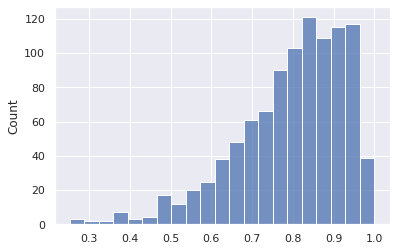

In [12]:
sns.histplot(x=f1)

# Real __Big__ and *small* models



No handles with labels found to put in legend.


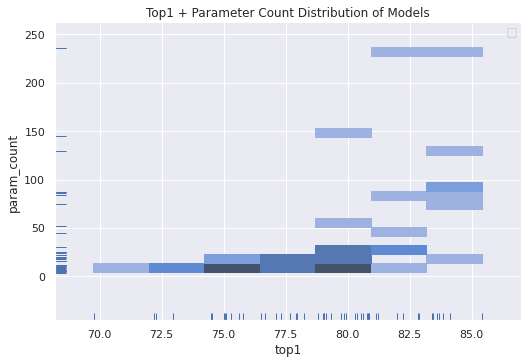

In [15]:
sns.displot(data=df, x='top1', y='param_count', rug=True, legend=True, aspect=1.5)
plt.title('Top1 + Parameter Count Distribution of Models')
plt.legend()

In [16]:
def dis_from_sym(p):
    return np.mean(np.abs(p[:, 0] - p[:, 1]))

In [17]:
def return_compression_errors(base_fpr, base_fnr, fpr, fnr):
    
    classes = 1000
    
    # get method stats
    FPR_change = (fpr - base_fpr)/base_fpr 
    FNR_change = (fnr - base_fnr)/base_fnr 
    
    # make class points
    points = np.dstack((FPR_change, FNR_change))[0]
    
    #we should use my hand-coded variance, or mse
    return my_special_variance(points), dis_from_sym(points)

In [18]:
FPR += 1e-150
FNR += 1e-150

In [19]:
stacked = np.dstack((FPR, FNR))[0]

In [20]:
dis_from_sym(stacked)

0.20669769769769772

In [21]:
np.var(stacked)

0.02284929383116851

In [22]:
model_count = len(df)
matrix = np.zeros((model_count, model_count))
matrix_sde = np.zeros((model_count, model_count))

In [310]:
def plot_cev_sde(models_df, normalize=False):

  model_count = len(models_df)
  matrix = np.zeros((model_count, model_count))
  matrix_sde = np.zeros((model_count, model_count))
  matrix_acc = np.zeros((model_count, model_count))
  

  for count_i, (i, row) in enumerate(models_df.iterrows()):
    ground_labels = models_df.loc[i, 'ground_labels']
    FPR, FNR = class_level_stats(ground_labels, models_df.loc[i, 'predictions'])
    acc = models_df.loc[i, 'top1']
    FPR += 1e-150
    FNR += 1e-150
    w_FPR, w_FNR = class_level_stats(ground_labels, np.random.randint(0, 999, size=(len(ground_labels))))
    w_cev, w_sde = return_compression_errors(FPR, FNR, w_FPR, w_FNR)
    for count_j, (j, row_d) in enumerate(models_df.iterrows()):
      FPR_n, FNR_n = class_level_stats(models_df.loc[j, 'ground_labels'], models_df.loc[j, 'predictions'])
      acc_n = models_df.loc[j, 'top1']
      FPR_n += 1e-150
      FNR_n += 1e-150
      cev, sde = return_compression_errors(FPR, FNR, FPR_n, FNR_n)
      acc_diff_pct = (acc_n - acc) / acc * 100
      if normalize:
        cev = cev / w_cev
        sde = sde / w_sde
      #print(models_df.loc[i, 'model'], " With respect to:", row_d['model'], "\t\t", cev, '\t', sde)
      matrix[count_i, count_j] = cev
      matrix_sde[count_i, count_j] = sde
      matrix_acc[count_i, count_j] = acc_diff_pct

  sns.set_theme(context="paper", font_scale=2.25)  
  plt.figure(figsize=(23, 7))
  ax_acc = plt.subplot(1, 3, 1)
  sns.heatmap(matrix_acc, cmap="YlGnBu_r")
  ax_acc.set_title('Change in Top1(%)')
  ax = plt.subplot(1, 3, 2)
  sns.heatmap(matrix, cmap="YlGnBu")
  ax_1 = plt.subplot(1, 3, 3)
  sns.heatmap(matrix_sde, cmap="YlGnBu")
  ax.set_title('CEV')
  ax_1.set_title('SDE')
  plt.tight_layout()

In [24]:
df[['model', 'top1', 'param_count', 'img_size']]

,model,top1,param_count,img_size
0,resnet50d,80.514,25.58,224
1,resnet33ts,79.136,19.68,256
2,resnet50,79.032,25.56,224
3,resnet32ts,79.020,17.96,256
4,resnet26t,77.686,16.01,256
5,resnet34d,77.106,21.82,224
6,resnet26d,76.680,16.01,224
7,resnet26,75.292,16.00,224
8,resnet34,75.112,21.80,224
9,resnet18d,72.270,11.71,224


# ResNets

In [25]:
df[df['model'].str.contains('^resnet[1-5].*')].sort_values('top1', ascending=False)

,model,top1,top1_err,top5,top5_err,param_count,img_size,cropt_pct,interpolation,ground_labels,predictions
0,resnet50d,80.514,19.486,95.170,4.830,25.58,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."
1,resnet33ts,79.136,20.864,94.542,5.458,19.68,256,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."
2,resnet50,79.032,20.968,94.384,5.616,25.56,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 391, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, ..."
3,resnet32ts,79.020,20.980,94.328,5.672,17.96,256,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."
4,resnet26t,77.686,22.314,93.724,6.276,16.01,256,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
5,resnet34d,77.106,22.894,93.370,6.630,21.82,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
6,resnet26d,76.680,23.320,93.166,6.834,16.01,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."
7,resnet26,75.292,24.708,92.570,7.430,16.00,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[391, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
8,resnet34,75.112,24.888,92.288,7.712,21.80,224,0.875,bilinear,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 939, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, ..."
9,resnet18d,72.270,27.730,90.698,9.302,11.71,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."


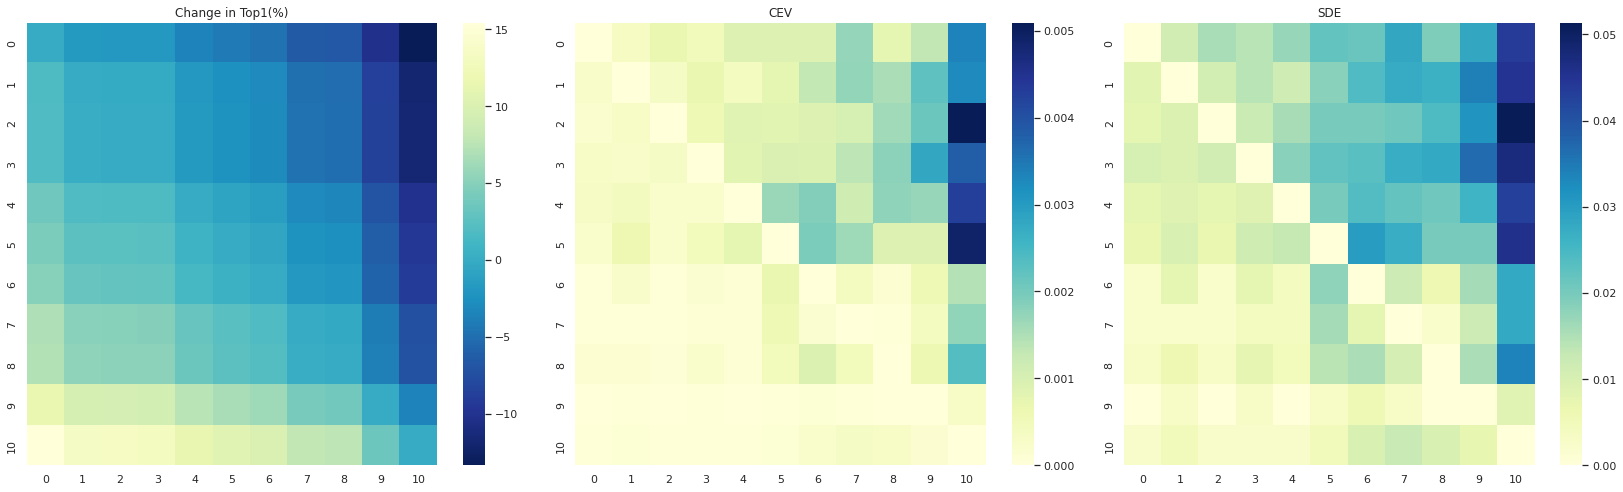

In [26]:
plot_cev_sde(df[df['model'].str.contains('^resnet[1-5].*')].sort_values('top1', ascending=False), normalize=True)

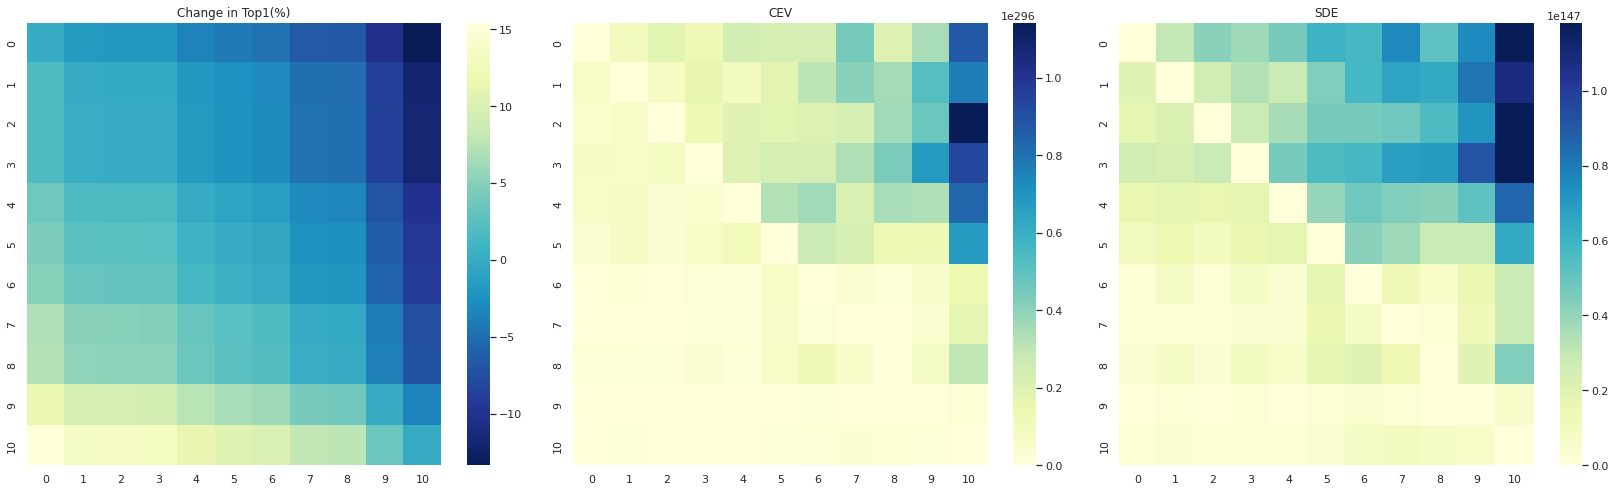

In [27]:
plot_cev_sde(df[df['model'].str.contains('^resnet[1-5].*')].sort_values('top1', ascending=False))

# Pruned

In [28]:
df[df['model'].str.contains('efficientnet_b[1-2]')].sort_values('param_count', ascending=False)

,model,top1,top1_err,top5,top5_err,param_count,img_size,cropt_pct,interpolation,ground_labels,predictions
48,efficientnet_b2,80.608,19.392,95.310,4.690,9.11,288,1.000,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 693, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, ..."
34,efficientnet_b2_pruned,79.918,20.082,94.848,5.152,8.31,260,0.890,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
49,efficientnet_b1,78.792,21.208,94.342,5.658,7.79,256,1.000,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
36,efficientnet_b1_pruned,78.242,21.758,93.832,6.168,6.33,240,0.882,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."


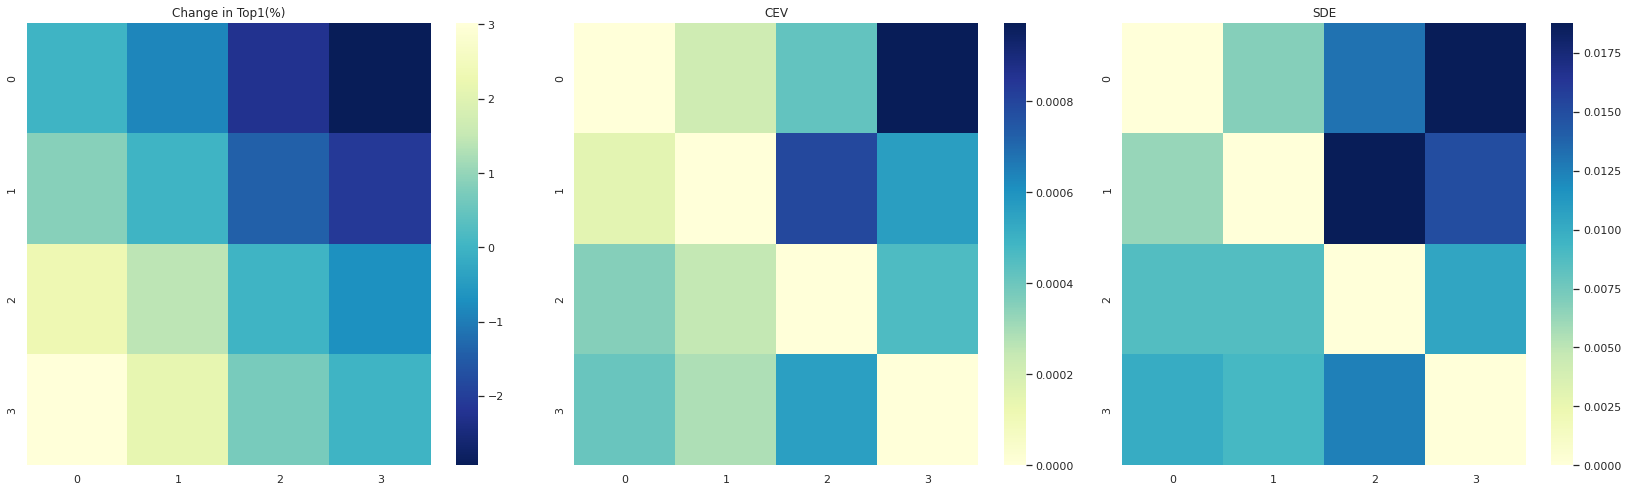

In [29]:
plot_cev_sde(df[df['model'].str.contains('efficientnet_b[1-2]')].sort_values('param_count', ascending=False), normalize=True)

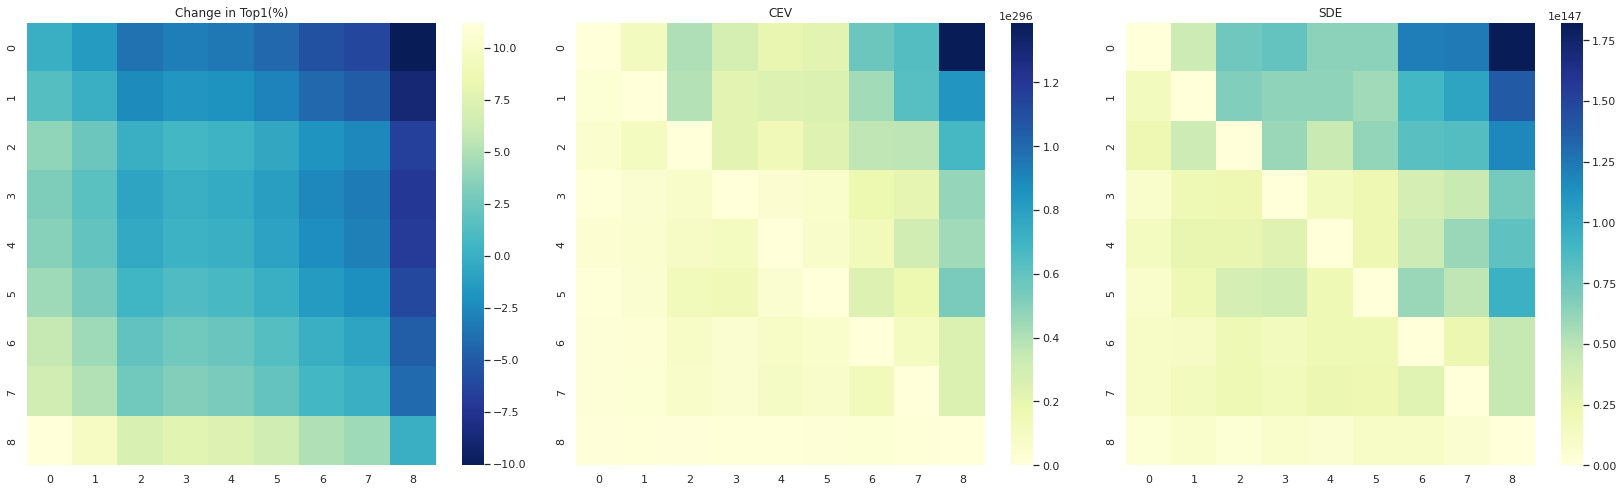

In [30]:
plot_cev_sde(df[df['model'].str.contains('efficient')].sort_values('param_count', ascending=False))

# Distilled

In [31]:
df[df['model'].str.contains('deit\w*patch16_224|regnety_160')].sort_values('top1', ascending=False)

,model,top1,top1_err,top5,top5_err,param_count,img_size,cropt_pct,interpolation,ground_labels,predictions
43,regnety_160,83.690,16.310,96.782,3.218,83.59,288,1.0,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
21,deit_base_distilled_patch16_224,83.386,16.614,96.488,3.512,87.34,224,0.9,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[390, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
40,deit_base_patch16_224,81.990,18.010,95.736,4.264,86.57,224,0.9,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[390, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
24,deit_small_distilled_patch16_224,81.216,18.784,95.386,4.614,22.44,224,0.9,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."
41,deit_small_patch16_224,79.852,20.148,95.044,4.956,22.05,224,0.9,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."
30,deit_tiny_distilled_patch16_224,74.504,25.496,91.890,8.110,5.91,224,0.9,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."
42,deit_tiny_patch16_224,72.176,27.824,91.114,8.886,5.72,224,0.9,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."


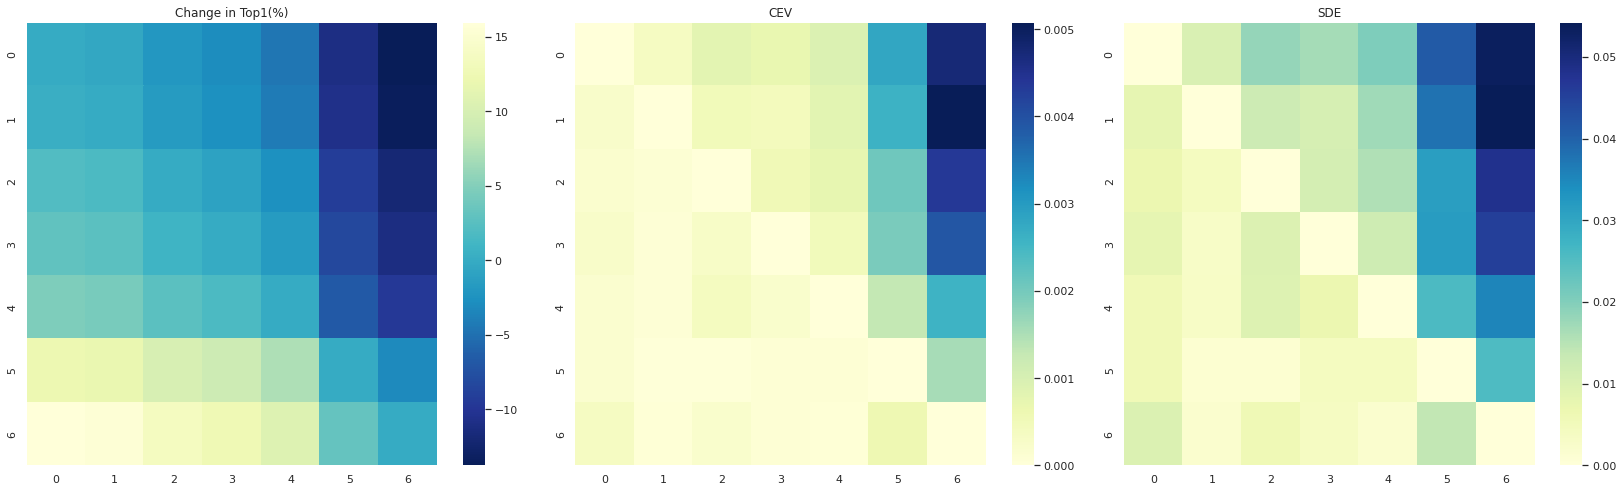

In [32]:
plot_cev_sde(df[df['model'].str.contains('deit\w*patch16_224|regnety_160')].sort_values('top1', ascending=False), normalize=True)

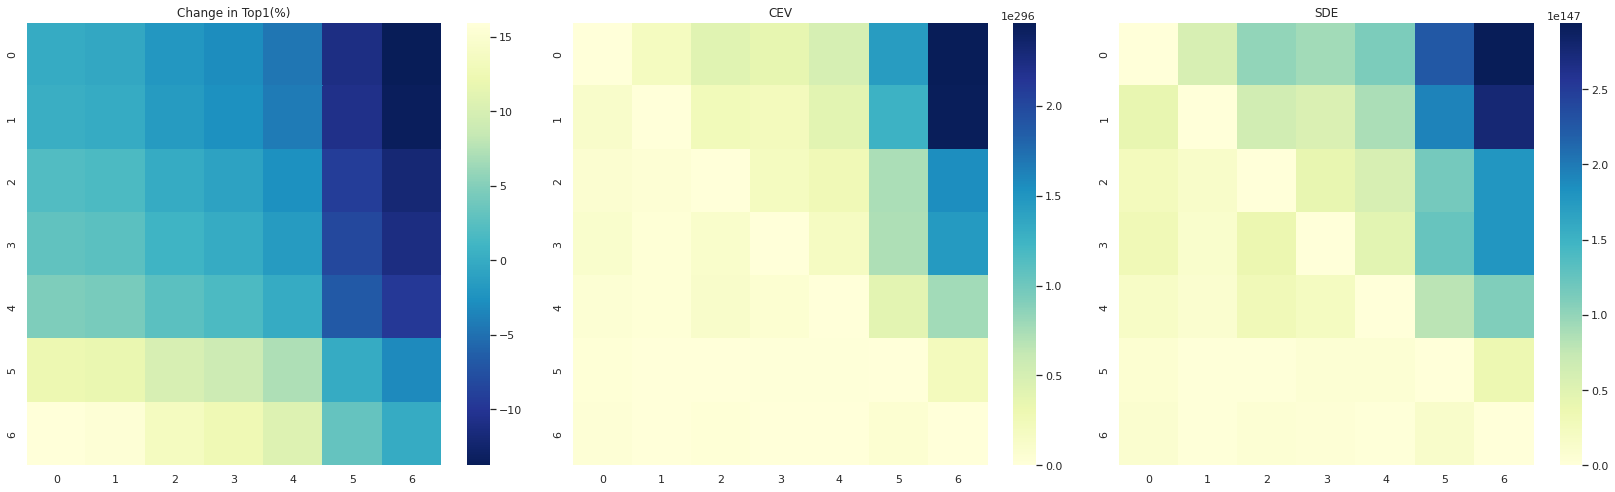

In [33]:
plot_cev_sde(df[df['model'].str.contains('deit\w*patch16_224|regnety_160')].sort_values('top1', ascending=False))

# Patient Teacher

In [34]:
df[df['model'].str.contains('bit_distilled|bit_teacher$|resnet\w*pruned')].sort_values('top1', ascending=False)

,model,top1,top1_err,top5,top5_err,param_count,img_size,cropt_pct,interpolation,ground_labels,predictions
39,resnetv2_152x2_bit_teacher,82.882,17.118,96.588,3.412,236.34,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."
22,resnetv2_50x1_bit_distilled,82.826,17.174,96.514,3.486,25.55,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
32,ecaresnet101d_pruned,80.808,19.192,95.628,4.372,24.88,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
35,ecaresnet50d_pruned,79.718,20.282,94.890,5.110,19.94,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."


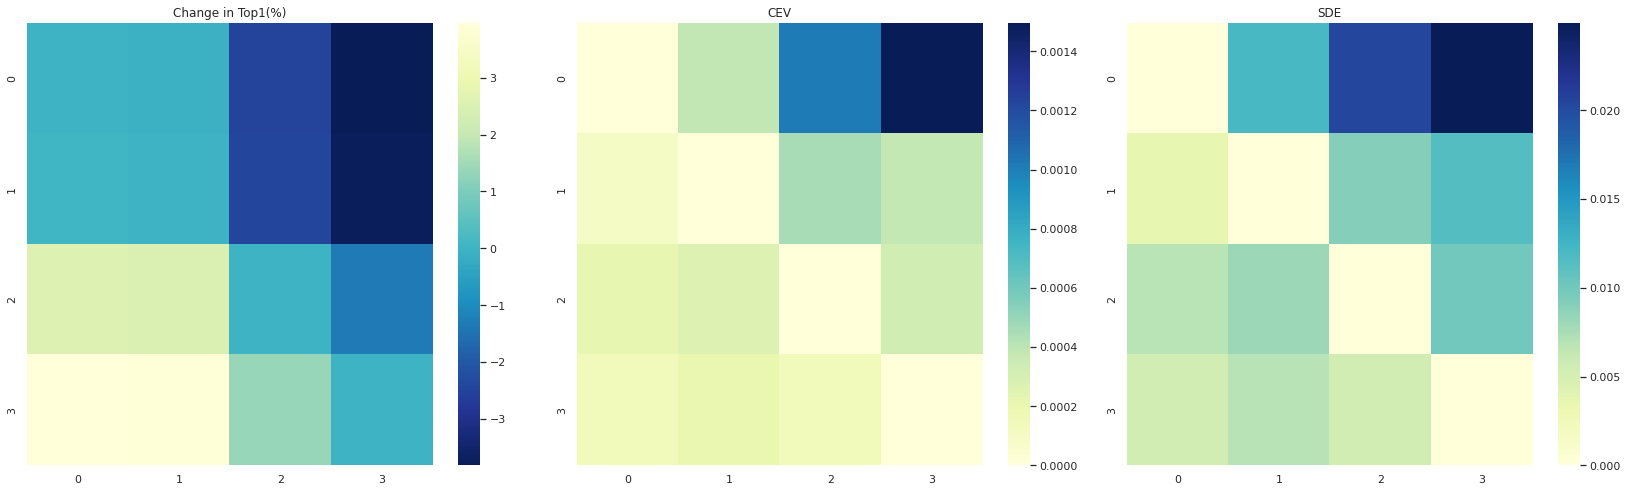

In [35]:
plot_cev_sde(df[df['model'].str.contains('bit_distilled|bit_teacher$|resnet\w*pruned')].sort_values('top1', ascending=False), normalize=True)

In [36]:
df.nsmallest(20, 'param_count').sort_values(['model', 'top1'], ascending=[True, False])[['model', 'top1','top5', 'img_size', 'param_count']]

,model,top1,top5,img_size,param_count
30,deit_tiny_distilled_patch16_224,74.504,91.890,224,5.91
42,deit_tiny_patch16_224,72.176,91.114,224,5.72
49,efficientnet_b1,78.792,94.342,256,7.79
36,efficientnet_b1_pruned,78.242,93.832,240,6.33
48,efficientnet_b2,80.608,95.310,288,9.11
34,efficientnet_b2_pruned,79.918,94.848,260,8.31
31,efficientnet_b3_pruned,80.856,95.240,300,9.86
33,efficientnet_el_pruned,80.304,95.222,300,10.59
37,efficientnet_es_pruned,75.006,92.438,224,5.44
17,mobilenetv2_100,72.978,91.016,224,3.50


In [37]:
df.nsmallest(20, 'param_count').sort_values(['model', 'top1'], ascending=[True, False]).reset_index()

,index,model,top1,top1_err,top5,top5_err,param_count,img_size,cropt_pct,interpolation,ground_labels,predictions
0,30,deit_tiny_distilled_patch16_224,74.504,25.496,91.890,8.110,5.91,224,0.900,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."
1,42,deit_tiny_patch16_224,72.176,27.824,91.114,8.886,5.72,224,0.900,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."
2,49,efficientnet_b1,78.792,21.208,94.342,5.658,7.79,256,1.000,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
3,36,efficientnet_b1_pruned,78.242,21.758,93.832,6.168,6.33,240,0.882,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
4,48,efficientnet_b2,80.608,19.392,95.310,4.690,9.11,288,1.000,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 693, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, ..."
5,34,efficientnet_b2_pruned,79.918,20.082,94.848,5.152,8.31,260,0.890,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
6,31,efficientnet_b3_pruned,80.856,19.144,95.240,4.760,9.86,300,0.904,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 693, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
7,33,efficientnet_el_pruned,80.304,19.696,95.222,4.778,10.59,300,0.904,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
8,37,efficientnet_es_pruned,75.006,24.994,92.438,7.562,5.44,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."
9,17,mobilenetv2_100,72.978,27.022,91.016,8.984,3.50,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."


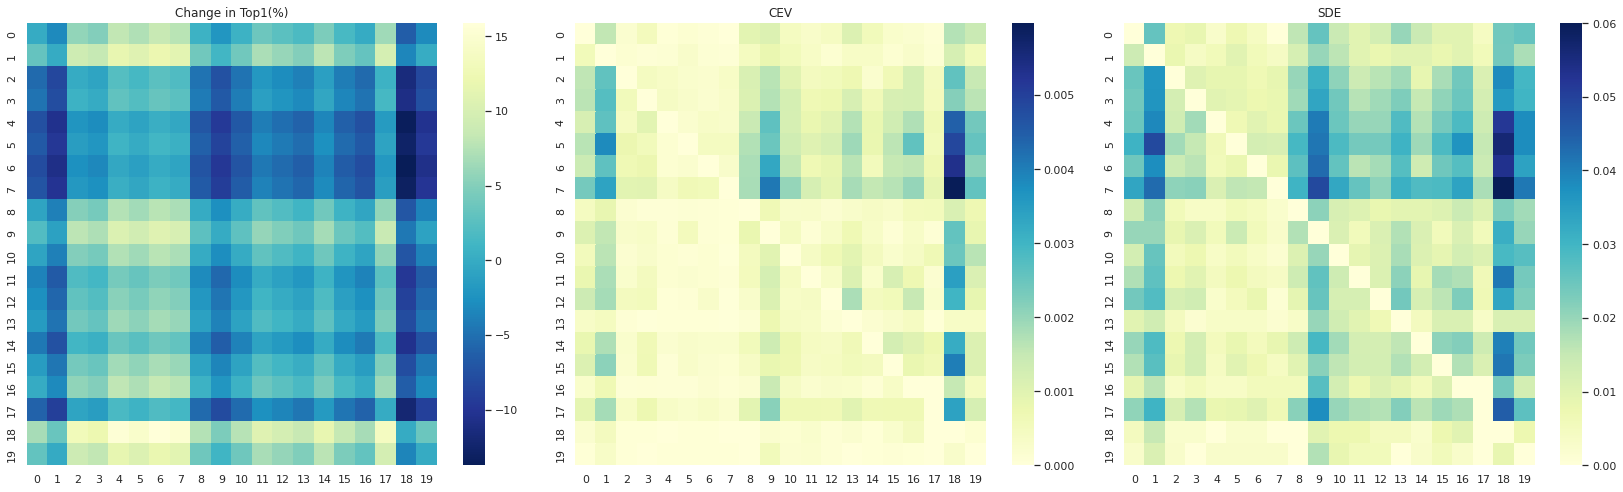

In [43]:
plot_cev_sde(df.nsmallest(20, 'param_count').sort_values(['model', 'top1'], ascending=[True, False]).reset_index(), normalize=True)

In [306]:
df.query('model in @model_list').sort_values(['top1'], ascending=[False])[['model', 'top1','top5', 'img_size', 'param_count']].reset_index().drop(columns='index').reset_index().to_latex(index=False)

'\\begin{tabular}{rlrrrr}\n\\toprule\n index &                            model &    top1 &    top5 &  img\\_size &  param\\_count \\\\\n\\midrule\n     0 &                  efficientnet\\_b2 &  80.608 &  95.310 &       288 &         9.11 \\\\\n     1 &                  efficientnet\\_b1 &  78.792 &  94.342 &       256 &         7.79 \\\\\n     2 &           efficientnet\\_b1\\_pruned &  78.242 &  93.832 &       240 &         6.33 \\\\\n     3 &       mobilenetv3\\_large\\_100\\_miil &  77.914 &  92.914 &       224 &         5.48 \\\\\n     4 &                 mobilenetv2\\_120d &  77.294 &  93.502 &       224 &         5.83 \\\\\n     5 &            mobilenetv3\\_large\\_100 &  75.768 &  92.540 &       224 &         5.48 \\\\\n     6 &                   mobilenetv3\\_rw &  75.628 &  92.708 &       224 &         5.48 \\\\\n     7 &                 mobilenetv2\\_110d &  75.052 &  92.180 &       224 &         4.52 \\\\\n     8 &             pit\\_ti\\_distilled\\_224 &  74.536 &  92.096 

In [292]:
df.nsmallest(20, 'param_count').sort_values(['top1'], ascending=False).reset_index()

,index,model,top1,top1_err,top5,top5_err,param_count,img_size,cropt_pct,interpolation,ground_labels,predictions
0,31,efficientnet_b3_pruned,80.856,19.144,95.240,4.760,9.86,300,0.904,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 693, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
1,48,efficientnet_b2,80.608,19.392,95.310,4.690,9.11,288,1.000,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 693, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, ..."
2,33,efficientnet_el_pruned,80.304,19.696,95.222,4.778,10.59,300,0.904,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
3,34,efficientnet_b2_pruned,79.918,20.082,94.848,5.152,8.31,260,0.890,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
4,27,pit_xs_distilled_224,79.310,20.690,94.364,5.636,11.00,224,0.900,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[390, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
5,49,efficientnet_b1,78.792,21.208,94.342,5.658,7.79,256,1.000,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
6,36,efficientnet_b1_pruned,78.242,21.758,93.832,6.168,6.33,240,0.882,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
7,11,mobilenetv3_large_100_miil,77.914,22.086,92.914,7.086,5.48,224,0.875,bilinear,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."
8,12,mobilenetv2_120d,77.294,22.706,93.502,6.498,5.83,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[391, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
9,13,mobilenetv2_140,76.524,23.476,92.990,7.010,6.11,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."


In [298]:
model_list = [
 'efficientnet_b2',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'mobilenetv3_large_100_miil',
 'mobilenetv2_120d',
 'mobilenetv3_large_100',
 'mobilenetv3_rw',
 'mobilenetv2_110d',
 'pit_ti_distilled_224',
 'deit_tiny_distilled_patch16_224',
 'mobilenetv2_100',
 'resnet18']

In [300]:
df.query('model in @model_list').sort_values(['top1'], ascending=False).reset_index()

,index,model,top1,top1_err,top5,top5_err,param_count,img_size,cropt_pct,interpolation,ground_labels,predictions
0,48,efficientnet_b2,80.608,19.392,95.310,4.690,9.11,288,1.000,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 693, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, ..."
1,49,efficientnet_b1,78.792,21.208,94.342,5.658,7.79,256,1.000,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
2,36,efficientnet_b1_pruned,78.242,21.758,93.832,6.168,6.33,240,0.882,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
3,11,mobilenetv3_large_100_miil,77.914,22.086,92.914,7.086,5.48,224,0.875,bilinear,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."
4,12,mobilenetv2_120d,77.294,22.706,93.502,6.498,5.83,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[391, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
5,14,mobilenetv3_large_100,75.768,24.232,92.540,7.460,5.48,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
6,15,mobilenetv3_rw,75.628,24.372,92.708,7.292,5.48,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 391, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, ..."
7,16,mobilenetv2_110d,75.052,24.948,92.180,7.820,4.52,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
8,29,pit_ti_distilled_224,74.536,25.464,92.096,7.904,5.10,224,0.900,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 391, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, ..."
9,30,deit_tiny_distilled_patch16_224,74.504,25.496,91.890,8.110,5.91,224,0.900,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."


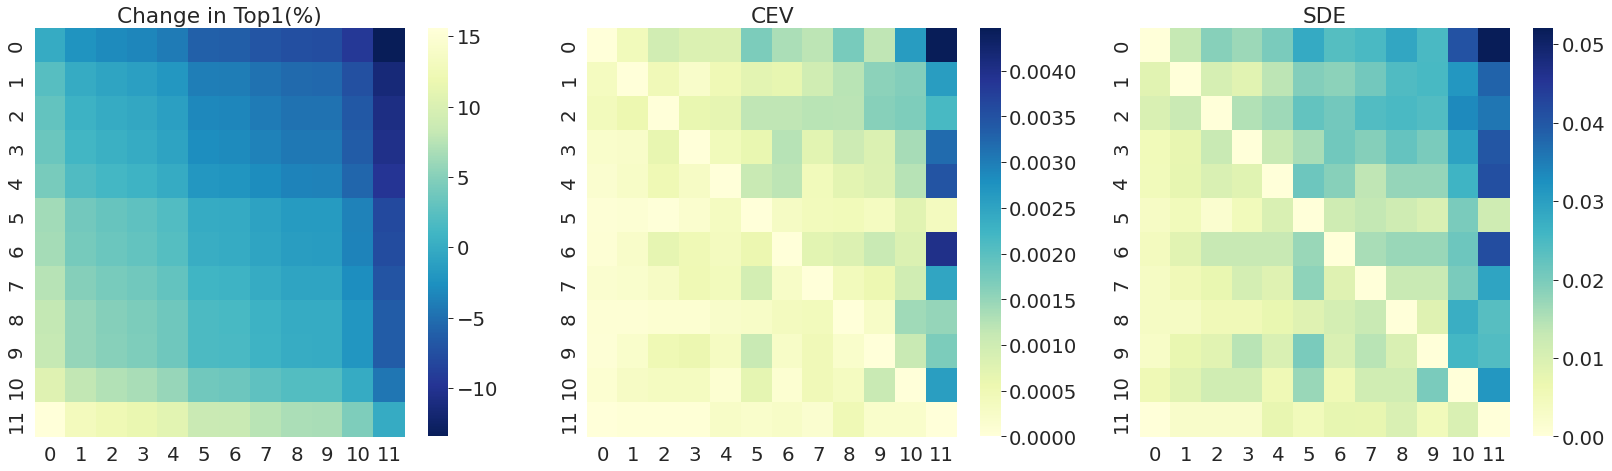

In [311]:
plot_cev_sde(df.query('model in @model_list').sort_values(['top1'], ascending=False).reset_index(), normalize=True)

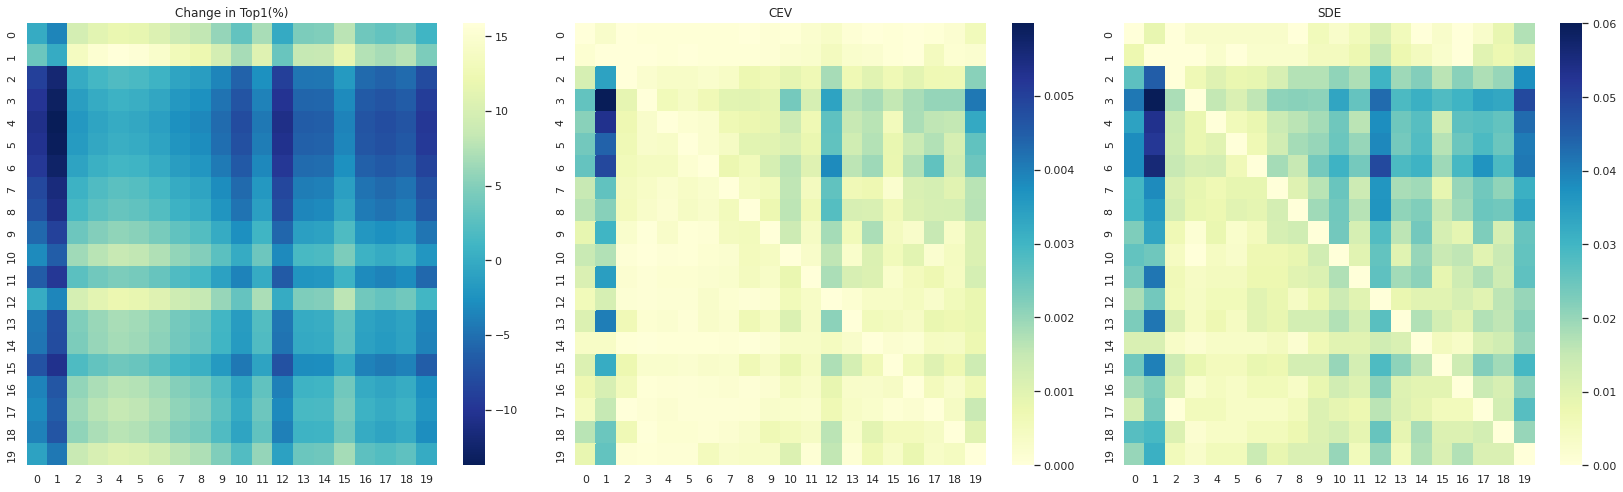

In [50]:
plot_cev_sde(df.nsmallest(20, 'param_count').sort_values(['param_count'], ascending=False).reset_index(), normalize=True)

In [52]:
df.nsmallest(20, 'param_count').sort_values(['param_count'], ascending=False).reset_index()

,index,model,top1,top1_err,top5,top5_err,param_count,img_size,cropt_pct,interpolation,ground_labels,predictions
0,9,resnet18d,72.270,27.730,90.698,9.302,11.71,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0, 0..."
1,10,resnet18,69.758,30.242,89.078,10.922,11.69,224,0.875,bilinear,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[48, 0, 391, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0..."
2,27,pit_xs_distilled_224,79.310,20.690,94.364,5.636,11.00,224,0.900,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[390, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
3,33,efficientnet_el_pruned,80.304,19.696,95.222,4.778,10.59,300,0.904,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
4,31,efficientnet_b3_pruned,80.856,19.144,95.240,4.760,9.86,300,0.904,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 693, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
5,48,efficientnet_b2,80.608,19.392,95.310,4.690,9.11,288,1.000,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 693, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, ..."
6,34,efficientnet_b2_pruned,79.918,20.082,94.848,5.152,8.31,260,0.890,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
7,49,efficientnet_b1,78.792,21.208,94.342,5.658,7.79,256,1.000,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
8,36,efficientnet_b1_pruned,78.242,21.758,93.832,6.168,6.33,240,0.882,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."
9,13,mobilenetv2_140,76.524,23.476,92.990,7.010,6.11,224,0.875,bicubic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[394, 0, 0, 0, 0, 0, 0, 0, 0, 0, 133, 0, 0, 0,..."


# New Section

<Figure size 504x360 with 0 Axes>

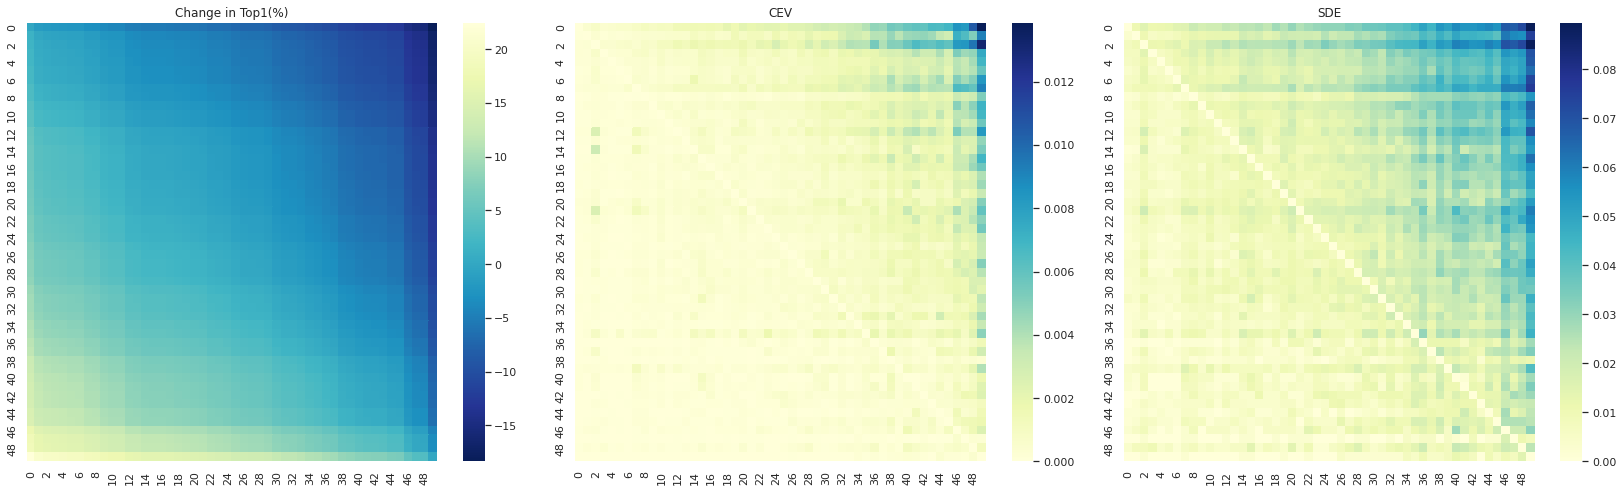

In [45]:
plt.figure(figsize=(7,5))
sns.set_style()
plot_cev_sde(df.sort_values('top1', ascending=False), normalize=True)

In [42]:
df.sort_values('top1', ascending=False)[['model', 'top1', 'param_count']]

,model,top1,param_count
18,deit_base_distilled_patch16_384,85.426,87.63
19,pit_b_distilled_224,84.140,74.79
38,resnetv2_152x2_bit_teacher_384,83.840,236.34
43,regnety_160,83.690,83.59
20,resmlp_big_24_distilled_224,83.590,129.14
46,efficientnet_b4,83.418,19.34
21,deit_base_distilled_patch16_224,83.386,87.34
39,resnetv2_152x2_bit_teacher,82.882,236.34
22,resnetv2_50x1_bit_distilled,82.826,25.55
47,efficientnet_b3,82.240,12.23
